# Model Impact

## Aim
- Reconcile historical rebalances with their impact on the book
- Regression: USD size of rebalance -> impact on book

## TODO
- Incorporate more model features; describe the book before the rebalance, incorporate macro indicators, etc
- Use better predictive modelling; tree models etc

In [1]:
%load_ext lab_black

In [114]:
import requests
import pandas as pd
import numpy as np
import tqdm
import pickle
import json
import nest_asyncio

from datetime import datetime, timedelta, date, time
import random

import seaborn as sns
import matplotlib.pyplot as plt

plt.style.use("ggplot")


pd.set_option("max_columns", 99)
pd.options.display.float_format = "{:.12f}".format

In [3]:
token_data = pd.DataFrame(
    requests.get(f"https://ftx.com/api//lt/tokens").json()["result"]
)
token_data = token_data[token_data.currentLeverage != 0]

In [4]:
all_underlying = token_data.underlying.unique()

In [5]:
with open("rebalance_data/ADABEAR", "rb") as f:
    rebalance_data = pickle.load(f)

### Combine LTs to their Underlying

In [98]:
import os

all_files = os.listdir("rebalance_data/")
master_rebalance = pd.DataFrame()
for underlying in all_underlying:
    _underlying_df = pd.DataFrame()
    _files = [x for x in all_files if underlying.replace("-PERP", "") in x]
    if len(_files) == 0:
        continue

    for f in _files:
        with open(f"rebalance_data/{f}", "rb") as f:
            rebalance_data = pickle.load(f)
            rebalance_data = rebalance_data[
                (rebalance_data.time.dt.time > time(0, 0, 0))
                & (rebalance_data.time.dt.time < time(0, 5, 0))
            ].copy()
            _underlying_df = _underlying_df.append(rebalance_data, ignore_index=True)
            _underlying_df["date"] = _underlying_df["time"].dt.date
            _underlying_df["usd_notional_fill"] = np.where(
                _underlying_df.side == "sell",
                _underlying_df.filledSize * _underlying_df.avgFillPrice * -1,
                _underlying_df.filledSize * _underlying_df.avgFillPrice,
            )
    _underlying_df = (
        _underlying_df.groupby("date")[["usd_notional_fill"]].sum().reset_index()
    )
    _underlying_df.insert(0, "instrument", underlying)
    master_rebalance = master_rebalance.append(_underlying_df, ignore_index=True)

In [106]:
master_rebalance = master_rebalance[master_rebalance.date >= date(2022, 1, 1)]

In [107]:
master_rebalance

,instrument,date,usd_notional_fill
800,ADA-PERP,2022-01-01,-1094995.853055000072
801,ADA-PERP,2022-01-02,1381995.841600000160
802,ADA-PERP,2022-01-03,-237031.338985000009
803,ADA-PERP,2022-01-04,-1105330.399179999949
804,ADA-PERP,2022-01-05,-309395.175120000029
...,...,...,...
35206,ZEC-PERP,2022-04-13,88986.126499999998
35207,ZEC-PERP,2022-04-15,-57802.800000000003
35208,ZEC-PERP,2022-04-17,-8406.096000000001
35209,ZEC-PERP,2022-04-18,-135830.560499999992


In [327]:
results = []
for inst in tqdm.tqdm(all_underlying):
    try:
        df = pd.read_csv(f"candle_data/{inst}.csv")
    except:
        continue
    df["time"] = pd.to_datetime(df["time"])

    _reb = master_rebalance[master_rebalance.instrument == inst].copy()

    for i, row in _reb.iterrows():
        _df = df[df["time"].dt.date == row["date"]].copy()
        _df = _df.loc[
            (_df["time"].dt.time >= time(0, 2, 0))
            & (_df["time"].dt.time <= time(0, 3, 0))
        ].sort_values("time")

        if _df.shape[0] == 0:
            continue

        if row["usd_notional_fill"] >= 0:
            _open = _df["open"].iloc[0]
            _max = _df["high"].max()
            delta = (_max - _open) / _open * 100
        else:
            _open = _df["open"].iloc[0]
            _min = _df["low"].min()
            delta = (_open - _min) / _open * 100

        results.append(
            {
                "instrument": inst,
                "date": row["date"],
                "usd_notional": row["usd_notional_fill"],
                "pct_move": delta,
            }
        )

100%|██████████| 47/47 [08:21<00:00, 10.68s/it]


<AxesSubplot:xlabel='abs_usd_notional', ylabel='pct_move'>

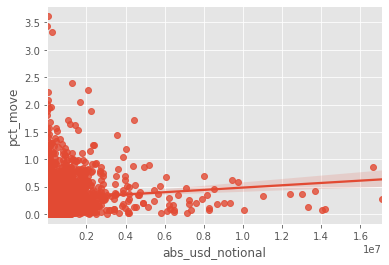

In [328]:
df_results = pd.DataFrame(results)
df_results["abs_usd_notional"] = abs(df_results.usd_notional)
sns.regplot(x=df_results["abs_usd_notional"], y=df_results.pct_move)

<AxesSubplot:xlabel='instrument'>

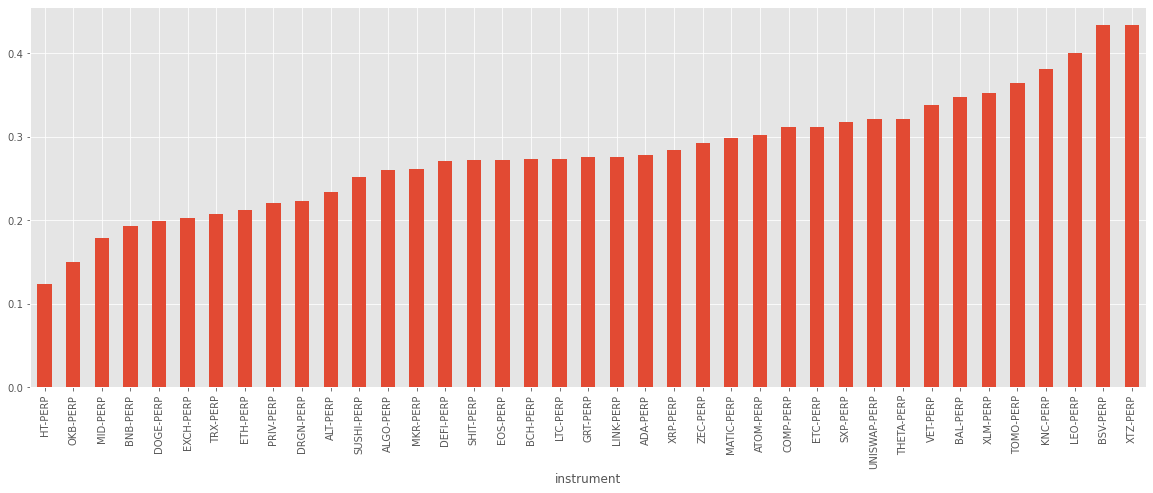

In [329]:
fig, ax = plt.subplots(figsize=(20, 7))
df_results.groupby("instrument").pct_move.mean().sort_values().plot(kind="bar")

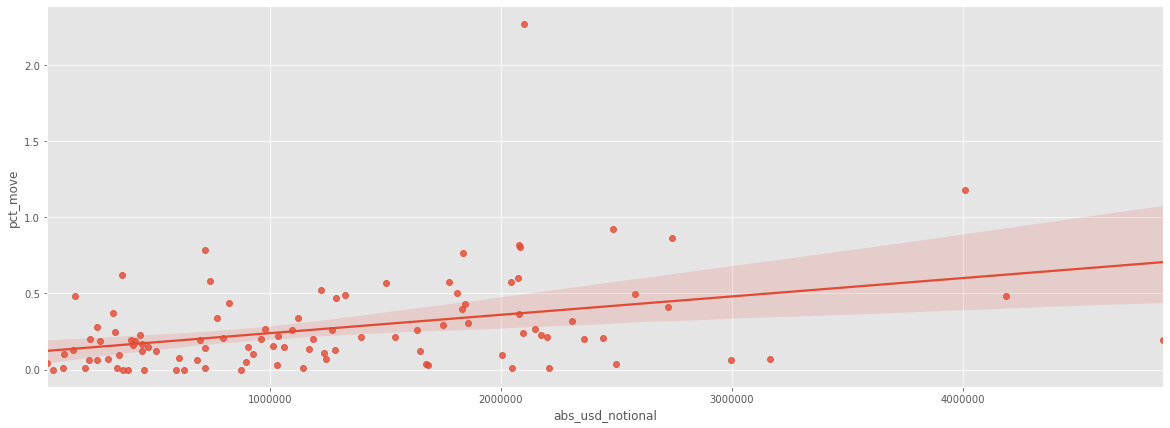

In [388]:
fig, ax = plt.subplots(figsize=(20, 7))
_df = df_results[df_results.instrument == "EOS-PERP"]
sns.regplot(x=_df.abs_usd_notional, y=_df.pct_move)

ax.ticklabel_format(style="plain")
ax.ticklabel_format(useOffset=False)

In [389]:
from sklearn.linear_model import LinearRegression, Ridge
from scipy import stats

In [390]:
slope, intercept, r, p, std_err = stats.linregress(_df.abs_usd_notional, _df.pct_move)

In [391]:
slope, intercept, r, p, std_err

(1.2052880749790457e-07,
 0.11818139021015314,
 0.3695906883756435,
 0.00012197382004781621,
 3.015198156741049e-08)

In [392]:
def pred(x):
    return slope * x + intercept

In [394]:
pred(712919.544774999842)

0.20410873278383285

In [378]:
df = pd.DataFrame(
    requests.get(f"https://ftx.com/api/lt/EOSBEAR/major_rebalances").json()["result"]
)
df["usd_notional"] = df.filledSize * df.avgFillPrice

display(df.head(6))

df = pd.DataFrame(
    requests.get(f"https://ftx.com/api/lt/EOSBULL/major_rebalances").json()["result"]
)
df["usd_notional"] = df.filledSize * df.avgFillPrice

display(df.head(6))

,time,side,avgFillPrice,filledSize,sentSize,usd_notional
0,2022-04-20T00:02:52.675658+00:00,buy,2.639344716104,93241.800000000003,93241.800000000003,246097.252149999986
1,2022-04-19T16:13:47.843875+00:00,buy,2.620816001052,751375.900000000023,751375.900000000023,1969217.981524999952
2,2022-04-19T00:02:52.793082+00:00,buy,2.448499984916,170712.100000000006,170712.100000000006,417988.574275000079
3,2022-04-18T00:02:38.040502+00:00,sell,2.410817277185,771410.099999999977,771410.099999999977,1859728.796875000000
4,2022-04-17T00:02:44.320481+00:00,sell,2.610188660281,42285.000000000000,42285.000000000000,110371.827499999999
5,2022-04-16T22:01:24.631901+00:00,buy,2.628185494358,796200.900000000023,796200.900000000023,2092563.655975000001


,time,side,avgFillPrice,filledSize,sentSize,usd_notional
0,2022-04-20T00:03:15.258435+00:00,buy,2.643494589748,553952.900000000023,553952.900000000023,1464371.494124999968
1,2022-04-19T00:03:15.213184+00:00,buy,2.454102147378,106348.300000000003,106348.300000000003,260989.591400000034
2,2022-04-18T00:03:00.579644+00:00,sell,2.412202298807,750306.699999999953,750306.699999999953,1809891.546549999854
3,2022-04-17T00:03:05.263487+00:00,buy,2.616888192554,843540.199999999953,843540.199999999953,2207450.389324999880
4,2022-04-15T00:03:09.719018+00:00,buy,2.312165405011,217095.600000000006,217095.600000000006,501960.935900000040
5,2022-04-13T00:02:57.091493+00:00,buy,2.255438345636,220994.899999999994,220994.899999999994,498440.371649999928
